In [2]:
import sys
sys.path.append("../")

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [17]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=50)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        if image_path == "no":
            pass
        else:
            if label == "BENIGN":
                labels.append(0)
            else:
                labels.append(1)
            # labels.append(label)
            image = cv2.imread(image_path)
            image = tf.image.resize(image, (299, 299)).numpy().astype("uint8")
            images.append(image)
    return np.array(images), np.array(labels)

In [18]:
train = pd.read_csv("../CBIS-DDSM/csv/mass_train_updated.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/mass_test_updated.csv", index_col=0)

In [19]:
BATCH_SIZE = 256
new_dataset_train_path = "../image_dataset/mass_dataset/full_images/train/"
new_dataset_val_path = "../image_dataset/mass_dataset/full_images/validation/"
new_dataset_test_path = "../image_dataset/mass_dataset/full_images/test/"

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(299, 299))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

images, labels = generate_test_data(test, image_type_path="image file path")

Found 1219 files belonging to 2 classes.
Found 243 files belonging to 2 classes.
Found 341 files belonging to 2 classes.


In [ ]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               input_shape=(299, 299, 3),  
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(299, 299, 3))

# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0     

In [10]:
history = model.fit(tf_train_dataset,
                    epochs=50,
                    batch_size=256,
                    validation_data=tf_test_dataset)

new_dataset_test_path = "../image_dataset/mass_dataset/full_images/test/"


tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(299, 299))

mets = model.evaluate(tf_test_dataset)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.5373

2023-05-15 16:10:31.703818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-15 16:10:31.704771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-15 16:10:32.418504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 23s 5s/step - loss: 0.7562 - accuracy: 0.5373 - val_loss: 0.6784 - val_accuracy: 0.6041
Epoch 2/50
5/5 [==============================] - 21s 4s/step - loss: 0.7064 - accuracy: 0.5726 - val_loss: 0.6659 - val_accuracy: 0.5982
Epoch 3/50
5/5 [==============================] - 19s 4s/step - loss: 0.6593 - accuracy: 0.6243 - val_loss: 0.6841 - val_accuracy: 0.5601
Epoch 4/50
5/5 [==============================] - 20s 4s/step - loss: 0.6326 - accuracy: 0.6432 - val_loss: 0.6631 - val_accuracy: 0.6041
Epoch 5/50
5/5 [==============================] - 19s 4s/step - loss: 0.6133 - accuracy: 0.6678 - val_loss: 0.6603 - val_accuracy: 0.6217
Epoch 6/50
5/5 [==============================] - 20s 4s/step - loss: 0.6030 - accuracy: 0.6751 - val_loss: 0.6705 - val_accuracy: 0.5894
Epoch 7/50
5/5 [==============================] - 20s 4s/step - loss: 0.5778 - accuracy: 0.6874 - val_loss: 0.6696 - val_accuracy: 0.5953
Epoch 8/50
5/5 [=============================

2023-05-15 16:28:18.525259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-15 16:28:18.526558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [341]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 5s 1s/step - loss: 0.8943 - accuracy: 0.6334
loss: 0.8943344354629517 
accuracy: 63.3431 %


In [20]:
y_pred = model.predict(tf_test_dataset)

print(classification_report(y_true=labels, y_pred=np.round(np.squeeze(y_pred))))

2023-05-15 16:47:50.060392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]
2023-05-15 16:47:50.060857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [341]
	 [[{{node Placeholder/_4}}]]


2/2 [==============================] - 4s 2s/step
              precision    recall  f1-score   support

           0       0.56      0.46      0.51       194
           1       0.42      0.52      0.46       147

    accuracy                           0.49       341
   macro avg       0.49      0.49      0.49       341
weighted avg       0.50      0.49      0.49       341



In [25]:
import plotly.express as px

In [34]:
confusion_matrix(labels, np.round(np.squeeze(y_pred))) 

array([[ 90, 104],
       [ 71,  76]])

In [38]:
90 104 

194

# 71 +76

In [35]:
tf_test_dataset.class_names

['BENIGN', 'MALIGNANT']

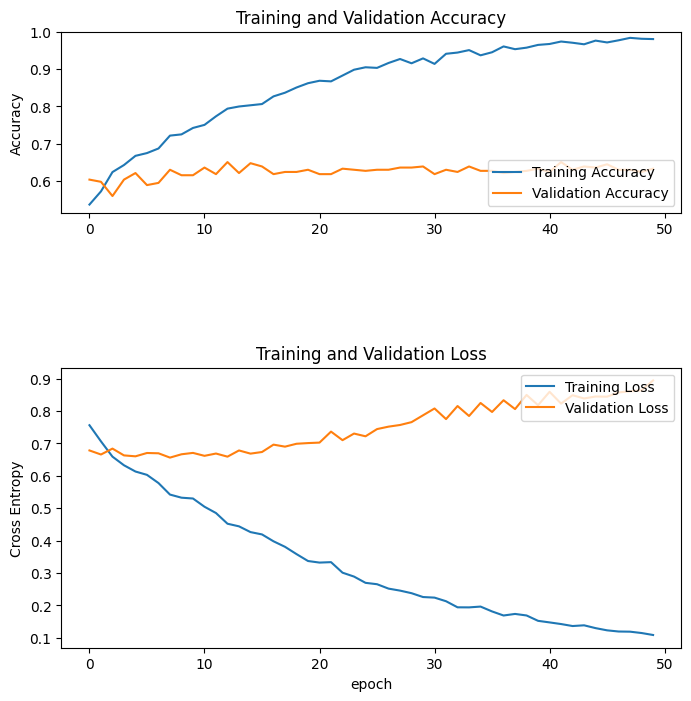

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()